In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import hydra
import itertools
import mlflow
import os
import numpy as np
import pandas as pd
import pathlib
import plotly.express as px
import torch
import xarray as xr

In [3]:
from smc01.postprocessing.lightning import SMC01Module
from smc01.postprocessing.cli.util import find_checkpoint_file, make_datasets, make_dataloader

In [ ]:
DATA_DIR = pathlib.Path(os.getenv('DATA_DIR'))

In [4]:
with hydra.initialize_config_module('smc01.postprocessing.conf'):
    cfg = hydra.compose('validate', ['experiment=attention_gdps_metar_reference'])

In [ ]:
cfg

In [6]:
CHECKPOINT_DIR = DATA_DIR / 'runs/postprocessing/multirun/2022-05-31/13-53-07/4854681'

In [7]:
CHECKPOINT_DIR = DATA_DIR / 'runs/postprocessing/multirun/2022-05-28/11-49-01/0'

In [8]:
CHECKPOINT_DIR = DATA_DIR / 'runs/postprocessing/multirun/2023-01-24/16-10-29/5199780'

In [9]:
CHECKPOINT_DIR = DATA_DIR / 'runs/postprocessing/multirun/2023-01-27/15-21-48/5217707'

In [10]:
CHECKPOINT_DIR = DATA_DIR / 'runs/postprocessing/multirun/2023-01-27/15-40-27/5217724'

In [11]:
CHECKPOINT_DIR = DATA_DIR / 'runs/postprocessing/multirun/2023-01-27/15-42-58/5217745'

In [12]:
CHECKPOINT_DIR = DATA_DIR / 'runs/postprocessing/multirun/2023-01-28/21-57-13/5224920'

In [13]:
CHECKPOINT_DIR = DATA_DIR / 'runs/postprocessing/multirun/2023-01-27/15-42-58/5217807'

In [14]:
CHECKPOINT_DIR = DATA_DIR / 'runs/postprocessing/multirun/2023-01-31/10-47-59/5225203'

In [102]:
CHECKPOINT_DIR = DATA_DIR / 'runs/postprocessing/multirun/2023-01-31/10-47-59/5225215'

In [103]:
checkpoint_file = find_checkpoint_file(CHECKPOINT_DIR)

In [104]:
ckpt = torch.load(checkpoint_file, map_location=torch.device('cpu'))

In [105]:
ckpt['state_dict']['model.step_embedding']

tensor([[-9.9593e-04,  2.9087e-04, -1.3648e-05,  ...,  1.2336e-03,
         -1.0510e-03, -2.2088e-03],
        [-4.4229e-04, -1.0984e-03,  1.5797e-03,  ...,  1.4660e-03,
          2.3009e-05,  1.8858e-03],
        [ 3.9571e-04, -6.7107e-04,  6.1238e-04,  ...,  2.2575e-03,
          1.4117e-04,  9.3100e-06],
        ...,
        [-9.7218e-04,  1.5975e-03, -3.0468e-03,  ...,  1.5783e-03,
          9.7787e-06, -1.8328e-03],
        [-1.4092e-03,  4.1529e-03, -4.1955e-03,  ..., -4.3998e-03,
          2.5034e-04,  2.0758e-04],
        [-2.4725e-04,  5.0068e-03, -7.4518e-03,  ..., -1.2801e-02,
          5.7205e-04,  1.0138e-02]])

In [106]:
#model = hydra.utils.instantiate(cfg.experiment.model, 1226, 18)
#module = SMC01Module.load_from_checkpoint(find_checkpoint_file(CHECKPOINT_DIR), model=model, full_stations_file=DATA_DIR / 'interpolated/2022-04-20-full/stations.csv')

In [107]:
step_embedding = ckpt['state_dict']['model.step_embedding']

In [108]:
#forecast_embedding = ckpt['state_dict']['model.forecast_embedding']
#norm = forecast_embedding.norm(dim=1)
#proximity = torch.matmul(forecast_embedding, forecast_embedding.T) / torch.matmul(norm, norm.T)
#fig = px.imshow(proximity.detach().numpy()[::, ::], height=600, width=700, origin='lower')
#fig

In [109]:
#proximity.fill_diagonal_(0.0)

In [110]:
NORM_A = step_embedding.norm(dim=1)

In [111]:
step_embedding.shape

torch.Size([81, 512])

In [112]:
NORM_A

tensor([0.0876, 0.0478, 0.0412, 0.0457, 0.0391, 0.0796, 0.0610, 0.0683, 0.0471,
        0.0705, 0.0604, 0.0377, 0.0636, 0.0303, 0.0369, 0.0577, 0.0497, 0.0418,
        0.0845, 0.0707, 0.0495, 0.0542, 0.0706, 0.0456, 0.0500, 0.0592, 0.0674,
        0.0604, 0.0942, 0.0419, 0.0526, 0.0600, 0.0867, 0.0417, 0.0414, 0.0456,
        0.0461, 0.0342, 0.0545, 0.0627, 0.0471, 0.0364, 0.0370, 0.0618, 0.0294,
        0.0528, 0.0422, 0.0491, 0.0449, 0.0411, 0.0438, 0.0470, 0.0455, 0.0763,
        0.0617, 0.0417, 0.0626, 0.0379, 0.0374, 0.0765, 0.0461, 0.0328, 0.0587,
        0.0589, 0.0312, 0.0508, 0.0753, 0.0677, 0.1003, 0.0767, 0.0882, 0.1004,
        0.1314, 0.0844, 0.1073, 0.2154, 0.1390, 0.1320, 0.1145, 0.1519, 0.3066])

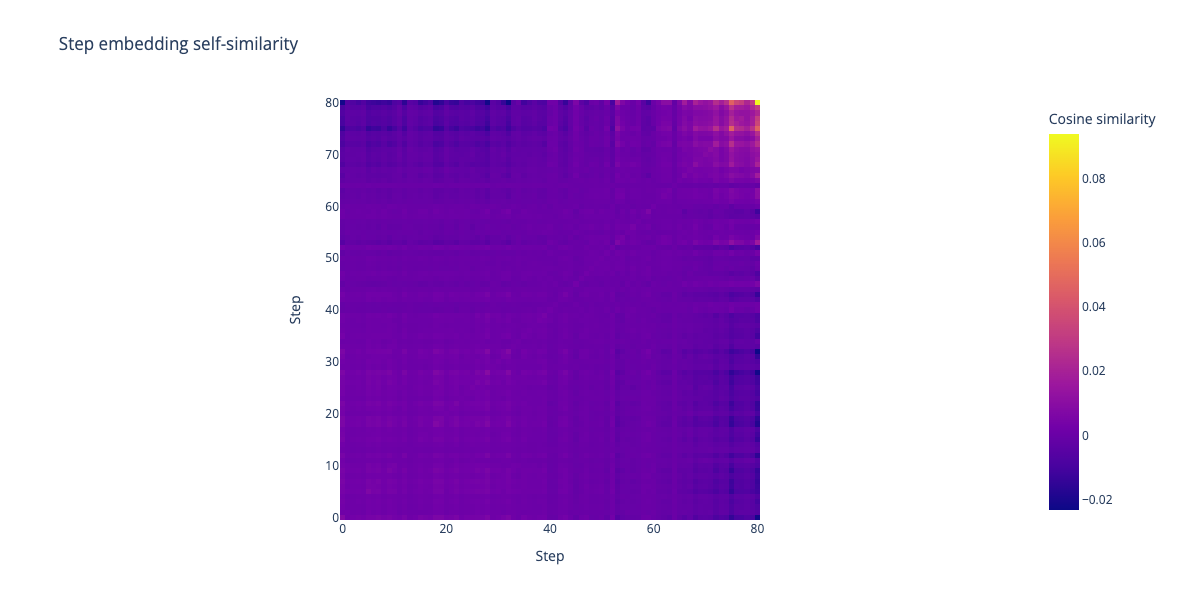

In [113]:
proximity = torch.matmul(step_embedding, step_embedding.T) / torch.matmul(NORM_A, NORM_A.T)
proximity = torch.matmul(step_embedding, step_embedding.T)

fig = px.imshow(proximity.detach().numpy()[::, ::], height=600, width=700, origin='lower', title='Step embedding self-similarity', labels={'color': 'Cosine similarity', 'x': 'Step', 'y': 'Step'})
#fig.write_image('step_embedding.png')
fig

In [114]:
stn_embedding = ckpt['state_dict']['model.station_embedding']
norm = stn_embedding.norm(dim=1)
proximity = torch.matmul(stn_embedding, stn_embedding.T) / torch.matmul(norm, norm.T)
#fig = px.imshow(proximity.detach().numpy()[::, ::], height=600, width=700, origin='lower')
#fig

In [115]:
stn_embedding = ckpt['state_dict']['model.station_embedding']
stn_norm = stn_embedding.norm(dim=1)
stn_proximity = torch.matmul(stn_embedding, stn_embedding.T) / torch.matmul(stn_norm, stn_norm.T)

In [116]:
stn_proximity

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -1.6816e-42,
         -1.1365e-42, -9.9674e-42],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -2.1230e-42,
         -1.8105e-42,  2.4046e-42],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -1.0790e-43,
          2.9708e-43,  2.6625e-43],
        ...,
        [-1.6816e-42, -2.1230e-42, -1.0790e-43,  ...,  5.5230e-04,
          4.1812e-04, -9.2414e-04],
        [-1.1365e-42, -1.8105e-42,  2.9708e-43,  ...,  4.1812e-04,
          4.9558e-04, -1.1886e-03],
        [-9.9674e-42,  2.4046e-42,  2.6625e-43,  ..., -9.2414e-04,
         -1.1886e-03,  2.8263e-02]])

In [117]:
stn_meta = pd.read_csv(DATA_DIR / 'interpolated/2021-12-20-gdps-metar/stations_w_metadata.csv')

In [118]:
stn_meta

,station,latitude,longitude,elevation
0,04W,46.0229,-92.8952,311.00
1,06D,48.8844,-99.6208,555.00
2,0E0,34.9856,-106.0095,1889.00
3,0F2,33.6017,-97.7756,335.60
4,0S9,48.0538,-122.8106,34.02
...,...,...,...,...
1221,Y70,42.9380,-85.0606,249.30
1222,YIP,42.2379,-83.5304,215.00
1223,YKM,46.5682,-120.5441,325.00
1224,YNG,41.2544,-80.6739,360.00


In [119]:
stn_meta[stn_meta['station'] == 'CYPH']

,station,latitude,longitude,elevation
397,CYPH,58.4719,-78.0769,3.0


In [120]:
lat = np.deg2rad(stn_meta['latitude'].to_numpy()).reshape(-1, 1)
lon = np.deg2rad(stn_meta['longitude'].to_numpy()).reshape(-1, 1)

lon[lon < 0.0] += 2 * np.pi

In [121]:
cos_delta_lambda = np.cos(lon - lon.T)

In [122]:
cos_cos_cos = (np.cos(lat) * np.cos(lat.T)) * cos_delta_lambda

In [123]:
sin_sin = np.sin(lat) * np.sin(lat.T)

In [124]:
distances = np.arccos(sin_sin + cos_cos_cos)
np.fill_diagonal(distances, 0.0)

<ipython-input-124-795705c6bbd8>:1: RuntimeWarning:

invalid value encountered in arccos



In [125]:
distances.shape

(1226, 1226)

In [126]:
stn_proximity.shape

torch.Size([1227, 1227])

In [127]:
stn_proximity

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -1.6816e-42,
         -1.1365e-42, -9.9674e-42],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -2.1230e-42,
         -1.8105e-42,  2.4046e-42],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -1.0790e-43,
          2.9708e-43,  2.6625e-43],
        ...,
        [-1.6816e-42, -2.1230e-42, -1.0790e-43,  ...,  5.5230e-04,
          4.1812e-04, -9.2414e-04],
        [-1.1365e-42, -1.8105e-42,  2.9708e-43,  ...,  4.1812e-04,
          4.9558e-04, -1.1886e-03],
        [-9.9674e-42,  2.4046e-42,  2.6625e-43,  ..., -9.2414e-04,
         -1.1886e-03,  2.8263e-02]])

In [128]:
stn_norm

tensor([0.0000, 0.0000, 0.0000,  ..., 0.5227, 0.4952, 3.7393])

In [129]:
norm_mask = np.abs(stn_norm[:-1]) > 1e-6

In [130]:
distance_mask = distances > 0.0

In [131]:
norm_mask = np.matmul(np.expand_dims(norm_mask, axis=1), np.expand_dims(norm_mask, axis=0))

In [132]:
triangular_mask = np.zeros_like(norm_mask, dtype=bool)
triangular_mask[np.tril_indices_from(triangular_mask)] = True

In [133]:
masked_distances = distances[norm_mask & distance_mask & triangular_mask]
masked_proximities = stn_proximity[:-1,:-1][norm_mask & distance_mask & triangular_mask]

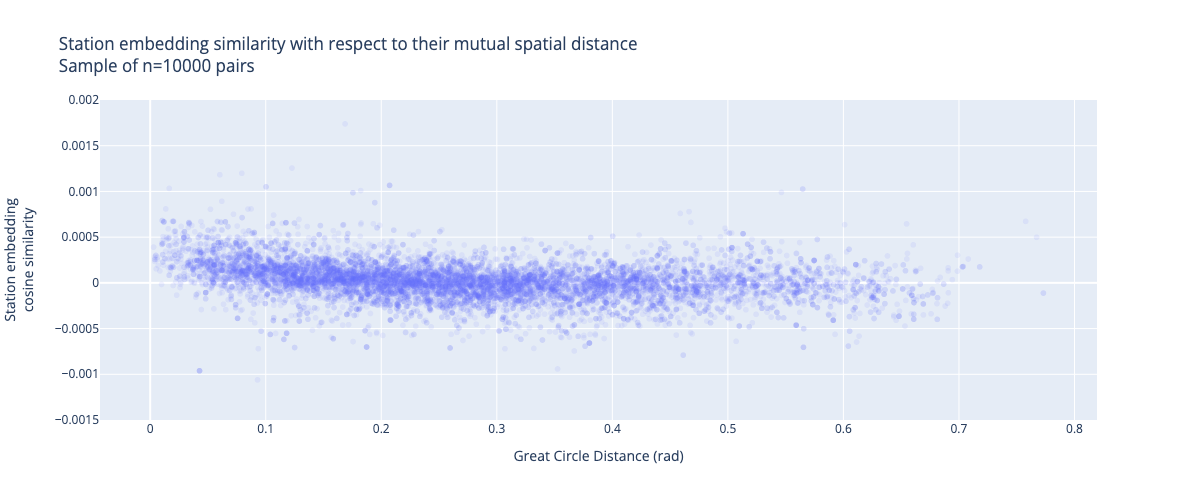

In [134]:
sample_size = 10000
sample = np.random.choice(np.arange(sample_size), sample_size)
d = masked_distances[sample]
p = masked_proximities[sample]

fig = px.scatter(x=d, y=p, range_y=(-0.0015, 0.0020), opacity=0.1,
                 labels={'x': 'Great Circle Distance (rad)', 'y': 'Station embedding<br>cosine similarity'},
                 title=f'Station embedding similarity with respect to their mutual spatial distance<br>Sample of n={sample_size} pairs',
                 height=500, width=800)
#fig.write_image('distance_similarity.png')
fig

In [135]:
#d = masked_distances[np.triu_indices(masked_distances.shape[0])]
#p = masked_proximities[np.triu_indices(masked_proximities.shape[0] - 1)]


In [136]:
stn_meta['proximity'] = stn_proximity[427, :-1].detach().numpy()

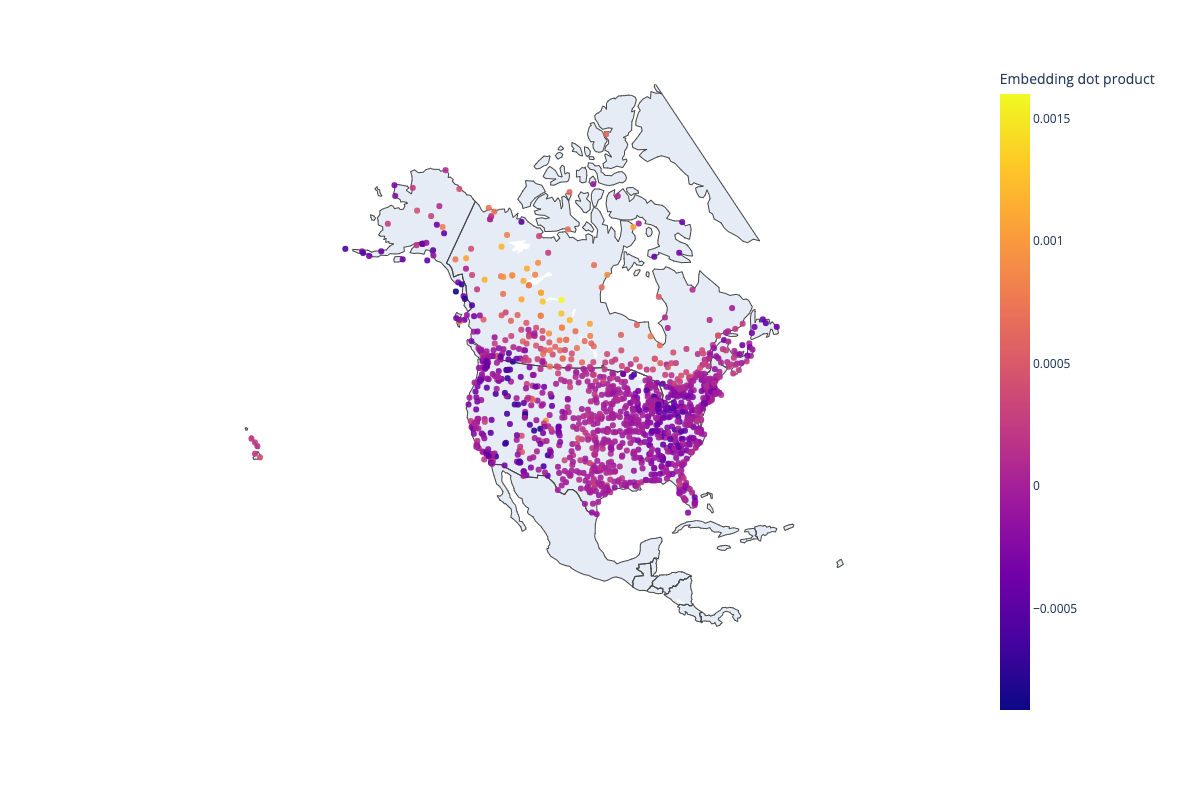

In [137]:
px.scatter_geo(data_frame=stn_meta, lat='latitude', lon='longitude', color='proximity', scope='north america', height=800, width=1000, opacity=0.9, hover_data=['station'], labels={'proximity': 'Embedding dot product'})